<a href="https://colab.research.google.com/github/sooo19/A-study-of-the-data-generation-model-of-the-Folk-Painting-source-data/blob/main/ImageCaptioning2(Maskrcnn%2C%20Meshed-memory%20Transfer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive/')
#Colab_Gdrive 연동

Mounted at /content/gdrive/


In [4]:
# Part of the code is borrowed from https://colab.research.google.com/drive/1vzrxDYB0vxtuUy8KCaGxm--nDCJvyBSg#scrollTo=HRUp0r_-B9N0&forceEdit=true&sandboxMode=true

In [5]:
# Install captioning repo and download the transformer pretrained model
%pip install git+https://github.com/ruotianluo/ImageCaptioning.pytorch.git
%pip install gdown
# !gdown --id 1KvRXqfVEXbCGj2LapfQ3py6bLjW9FatB
# !gdown --id 1Rsw1XukVghaaQt7TSrjNogu7_8Kp3n7G
!gdown --id 1VmUzgu0qlmCMqM1ajoOZxOXP3hiC_qlL
!gdown --id 1zQe00W02veVYq-hdq5WsPOS3OPkNdq79

  Cloning https://github.com/ruotianluo/ImageCaptioning.pytorch.git to /tmp/pip-req-build-4ue6oz0k
  Running command git clone -q https://github.com/ruotianluo/ImageCaptioning.pytorch.git /tmp/pip-req-build-4ue6oz0k
  Running command git submodule update --init --recursive -q
  Created wheel for captioning: filename=captioning-0.0.1-py3-none-any.whl size=66950 sha256=dd89642c97bbe2a8b3bf17da57009a9875104b335e6aa1607d0227fc3f9b52be
  Stored in directory: /tmp/pip-ephem-wheel-cache-fn58h64g/wheels/67/04/82/8cba9cd260b477d64712d4c1eb1a38e201cdb94cd9b3200955
Successfully built captioning
Downloading...
From: https://drive.google.com/uc?id=1VmUzgu0qlmCMqM1ajoOZxOXP3hiC_qlL
To: /content/model-best.pth
100% 230M/230M [00:01<00:00, 164MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zQe00W02veVYq-hdq5WsPOS3OPkNdq79
To: /content/infos_trans12-best.pkl
100% 777k/777k [00:00<00:00, 50.0MB/s]


In [6]:
!pip install yacs

In [7]:
# Install maskrcnn-benchmark to extract detectron features
%cd /content
!git clone https://gitlab.com/vedanuj/vqa-maskrcnn-benchmark.git
%cd /content/vqa-maskrcnn-benchmark
# Compile custom layers and build mask-rcnn backbone
!python setup.py build
!python setup.py develop
import sys
sys.path.append('/content/vqa-maskrcnn-benchmark')

/content
Cloning into 'vqa-maskrcnn-benchmark'...
remote: Enumerating objects: 764, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 764 (delta 10), reused 30 (delta 8), pack-reused 729
Receiving objects: 100% (764/764), 3.78 MiB | 12.61 MiB/s, done.
Resolving deltas: 100% (401/401), done.
/content/vqa-maskrcnn-benchmark
running build
running build_py
creating build
creating build/lib.linux-x86_64-3.7
creating build/lib.linux-x86_64-3.7/maskrcnn_benchmark
copying maskrcnn_benchmark/__init__.py -> build/lib.linux-x86_64-3.7/maskrcnn_benchmark
creating build/lib.linux-x86_64-3.7/maskrcnn_benchmark/solver
copying maskrcnn_benchmark/solver/build.py -> build/lib.linux-x86_64-3.7/maskrcnn_benchmark/solver
copying maskrcnn_benchmark/solver/lr_scheduler.py -> build/lib.linux-x86_64-3.7/maskrcnn_benchmark/solver
copying maskrcnn_benchmark/solver/__init__.py -> build/lib.linux-x86_64-3.7/maskrcnn_benchmark/solver
creating build/li

In [8]:
# Download the models for feature extraction
%cd /content/

%mkdir model_data
# !wget -O /content/model_data/detectron_model.pth  https://dl.fbaipublicfiles.com/pythia/detectron_model/detectron_model.pth 
# !wget -O /content/model_data/detectron_model.yaml https://dl.fbaipublicfiles.com/pythia/detectron_model/detectron_model.yaml

!wget -O /content/model_data/detectron_model.pth wget https://dl.fbaipublicfiles.com/vilbert-multi-task/detectron_model.pth
!wget -O /content/model_data/detectron_model.yaml wget https://dl.fbaipublicfiles.com/vilbert-multi-task/detectron_config.yaml

/content
--2021-11-10 06:25:22--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2021-11-10 06:25:22--  https://dl.fbaipublicfiles.com/vilbert-multi-task/detectron_model.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1661519645 (1.5G) [application/octet-stream]
Saving to: ‘/content/model_data/detectron_model.pth’

/content/model_data 100%[===================>]   1.55G  30.6MB/s    in 52s     

2021-11-10 06:26:15 (30.4 MB/s) - ‘/content/model_data/detectron_model.pth’ saved [1661519645/1661519645]

FINISHED --2021-11-10 06:26:15--
Total wall clock time: 53s
Downloaded: 1 files, 1.5G in 52s (30.4 MB/s)
--2021-11-10 06:26:15--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: u

In [9]:
import yaml
import cv2
import torch
import requests
import numpy as np
import gc
import torch.nn.functional as F
import pandas as pd


import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
from IPython.display import display, HTML, clear_output
from ipywidgets import widgets, Layout
from io import BytesIO


from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.layers import nms
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.structures.image_list import to_image_list
torch._six.PY3 = True  # fix for newer pytorch
from maskrcnn_benchmark.utils.model_serialization import load_state_dict


class FeatureExtractor:
  TARGET_IMAGE_SIZE = [448, 448]
  CHANNEL_MEAN = [0.485, 0.456, 0.406]
  CHANNEL_STD = [0.229, 0.224, 0.225]
  
  def __init__(self):
    # self._init_processors()
    self.detection_model = self._build_detection_model()
  
  def __call__(self, url):
    with torch.no_grad():
      detectron_features = self.get_detectron_features(url)
    
    return detectron_features
  
  def _build_detection_model(self):

      cfg.merge_from_file('/content/model_data/detectron_model.yaml')
      cfg.freeze()

      model = build_detection_model(cfg)
      checkpoint = torch.load('/content/model_data/detectron_model.pth', 
                              map_location=torch.device("cpu"))

      load_state_dict(model, checkpoint.pop("model"))

      model.to("cuda")
      model.eval()
      return model
  
  def get_actual_image(self, image_path):
      if image_path.startswith('http'):
          path = requests.get(image_path, stream=True).raw
      else:
          path = image_path
      return path

  def _image_transform(self, image_path):
      path = self.get_actual_image(image_path)

      img = Image.open(path)
      im = np.array(img).astype(np.float32)
      im = im[:, :, ::-1]
      im -= np.array([102.9801, 115.9465, 122.7717])
      im_shape = im.shape
      im_size_min = np.min(im_shape[0:2])
      im_size_max = np.max(im_shape[0:2])
      im_scale = float(800) / float(im_size_min)
      # Prevent the biggest axis from being more than max_size
      if np.round(im_scale * im_size_max) > 1333:
           im_scale = float(1333) / float(im_size_max)
      im = cv2.resize(
           im,
           None,
           None,
           fx=im_scale,
           fy=im_scale,
           interpolation=cv2.INTER_LINEAR
       )
      img = torch.from_numpy(im).permute(2, 0, 1)
      return img, im_scale


  def _process_feature_extraction(self, output,
                                 im_scales,
                                 feat_name='fc6',
                                 conf_thresh=0.2):
      batch_size = len(output[0]["proposals"])
      n_boxes_per_image = [len(_) for _ in output[0]["proposals"]]
      score_list = output[0]["scores"].split(n_boxes_per_image)
      score_list = [torch.nn.functional.softmax(x, -1) for x in score_list]
      feats = output[0][feat_name].split(n_boxes_per_image)
      cur_device = score_list[0].device

      feat_list = []

      for i in range(batch_size):
          dets = output[0]["proposals"][i].bbox / im_scales[i]
          scores = score_list[i]

          max_conf = torch.zeros((scores.shape[0])).to(cur_device)

          for cls_ind in range(1, scores.shape[1]):
              cls_scores = scores[:, cls_ind]
              keep = nms(dets, cls_scores, 0.5)
              max_conf[keep] = torch.where(cls_scores[keep] > max_conf[keep],
                                           cls_scores[keep],
                                           max_conf[keep])

          keep_boxes = torch.argsort(max_conf, descending=True)[:100]
          feat_list.append(feats[i][keep_boxes])
          print(feat_list)  # 추가
      return feat_list
    
  def get_detectron_features(self, image_path):
      im, im_scale = self._image_transform(image_path)
      img_tensor, im_scales = [im], [im_scale]
      current_img_list = to_image_list(img_tensor, size_divisible=32)
      current_img_list = current_img_list.to('cuda')
      with torch.no_grad():
          output = self.detection_model(current_img_list)
      feat_list = self._process_feature_extraction(output, im_scales, 
                                                  'fc6', 0.2)
      print(feat_list) # 추가
      return feat_list[0]

In [10]:
feature_extractor = FeatureExtractor()

In [11]:
import captioning
import captioning.utils.misc
import captioning.models
infos = captioning.utils.misc.pickle_load(open('infos_trans12-best.pkl', 'rb'))

Hugginface transformers not installed; please visit https://github.com/huggingface/transformers
meshed-memory-transformer not installed; please run `pip install git+https://github.com/ruotianluo/meshed-memory-transformer.git`


In [12]:
pip install git+https://github.com/ruotianluo/meshed-memory-transformer.git

  Cloning https://github.com/ruotianluo/meshed-memory-transformer.git to /tmp/pip-req-build-ga06odzz
  Running command git clone -q https://github.com/ruotianluo/meshed-memory-transformer.git /tmp/pip-req-build-ga06odzz
  Created wheel for meshed-memory-transformer: filename=meshed_memory_transformer-0.0.1-py3-none-any.whl size=39551 sha256=a549edb920be8b0a7325e223297930229caf37cad05ae2d38abc77501ec82f76
  Stored in directory: /tmp/pip-ephem-wheel-cache-m8nsf5o6/wheels/00/77/4c/9e10407a1f3322ca96a2c142682a6b5f5938e83f99b20eefdb
Successfully built meshed-memory-transformer


In [13]:
infos['opt'].vocab = infos['vocab']

In [14]:
model = captioning.models.setup(infos['opt'])
model.cuda()
model.load_state_dict(torch.load('model-best.pth'))

<All keys matched successfully>

In [15]:
def get_captions(img_feature):
    # Return the 5 captions from beam serach with beam size 5
    return model.decode_sequence(model(img_feature.mean(0)[None], img_feature[None], mode='sample', opt={'beam_size':5, 'sample_method':'beam_search', 'sample_n':5})[0])

[tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.2873,  ...,  0.0000,  0.0000,  2.6402],
        ...,
        [ 0.0000,  0.0000, 14.7595,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  6.9890,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  5.2893,  0.6226,  0.0000]],
       device='cuda:0')]
[tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.2873,  ...,  0.0000,  0.0000,  2.6402],
        ...,
        [ 0.0000,  0.0000, 14.7595,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  6.9890,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  5.2893,  0.6226,  0.0000]],
       device='cuda:0')]


Text(value='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn…

Button(description='Caption the image!', style=ButtonStyle())

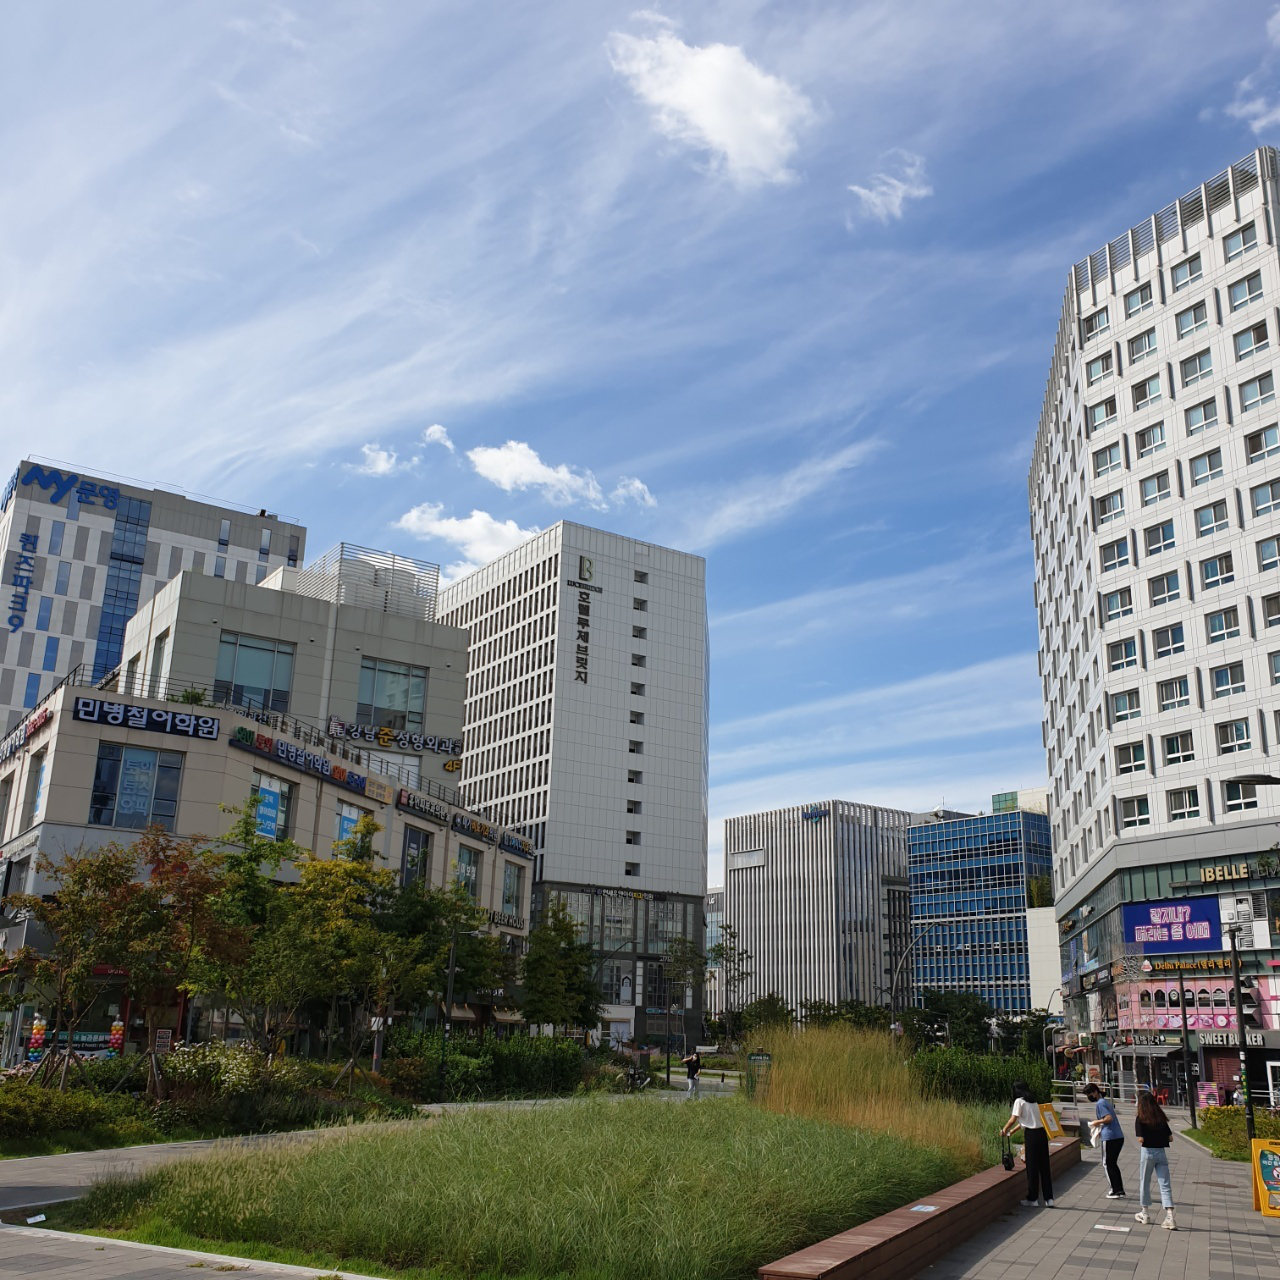

In [16]:
def init_widgets(url):
  image_text = widgets.Text(
    description="Image URL", layout=Layout(minwidth="70%")
  )

  image_text.value = url
  submit_button = widgets.Button(description="Caption the image!")

  display(image_text)
  display(submit_button)

  submit_button.on_click(lambda b: on_button_click(
      b, image_text
  ))
  
  return image_text
  
def on_button_click(b, image_text):   # 'Caption the image!' 버튼을 선택하면 이미지 캡셔닝이 진행됨.
  clear_output()
  image_path = feature_extractor.get_actual_image(image_text.value)
  image = Image.open(image_path)
  
  captions = '<br>'.join(get_captions(feature_extractor(image_text.value)))
  init_widgets(image_text.value)
  display(image)
  
  display(HTML(captions))

image_text = init_widgets(
    "https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FCII17%2Fbtrid7gTA30%2FTzAsCmgMrP9ocGkitH1rW1%2Fimg.jpg"
)

[tensor([[0.0000, 0.5019, 0.0000,  ..., 0.0000, 0.0000, 2.4155],
        [0.0000, 2.5696, 0.0000,  ..., 0.0000, 0.0000, 8.3900],
        [0.0000, 0.4744, 0.0000,  ..., 0.0000, 0.0000, 2.5323],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.9481],
        [0.0000, 0.0000, 7.1287,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 2.8878,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')]
[tensor([[0.0000, 0.5019, 0.0000,  ..., 0.0000, 0.0000, 2.4155],
        [0.0000, 2.5696, 0.0000,  ..., 0.0000, 0.0000, 8.3900],
        [0.0000, 0.4744, 0.0000,  ..., 0.0000, 0.0000, 2.5323],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.9481],
        [0.0000, 0.0000, 7.1287,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 2.8878,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')]


Text(value='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn…

Button(description='Caption the image!', style=ButtonStyle())

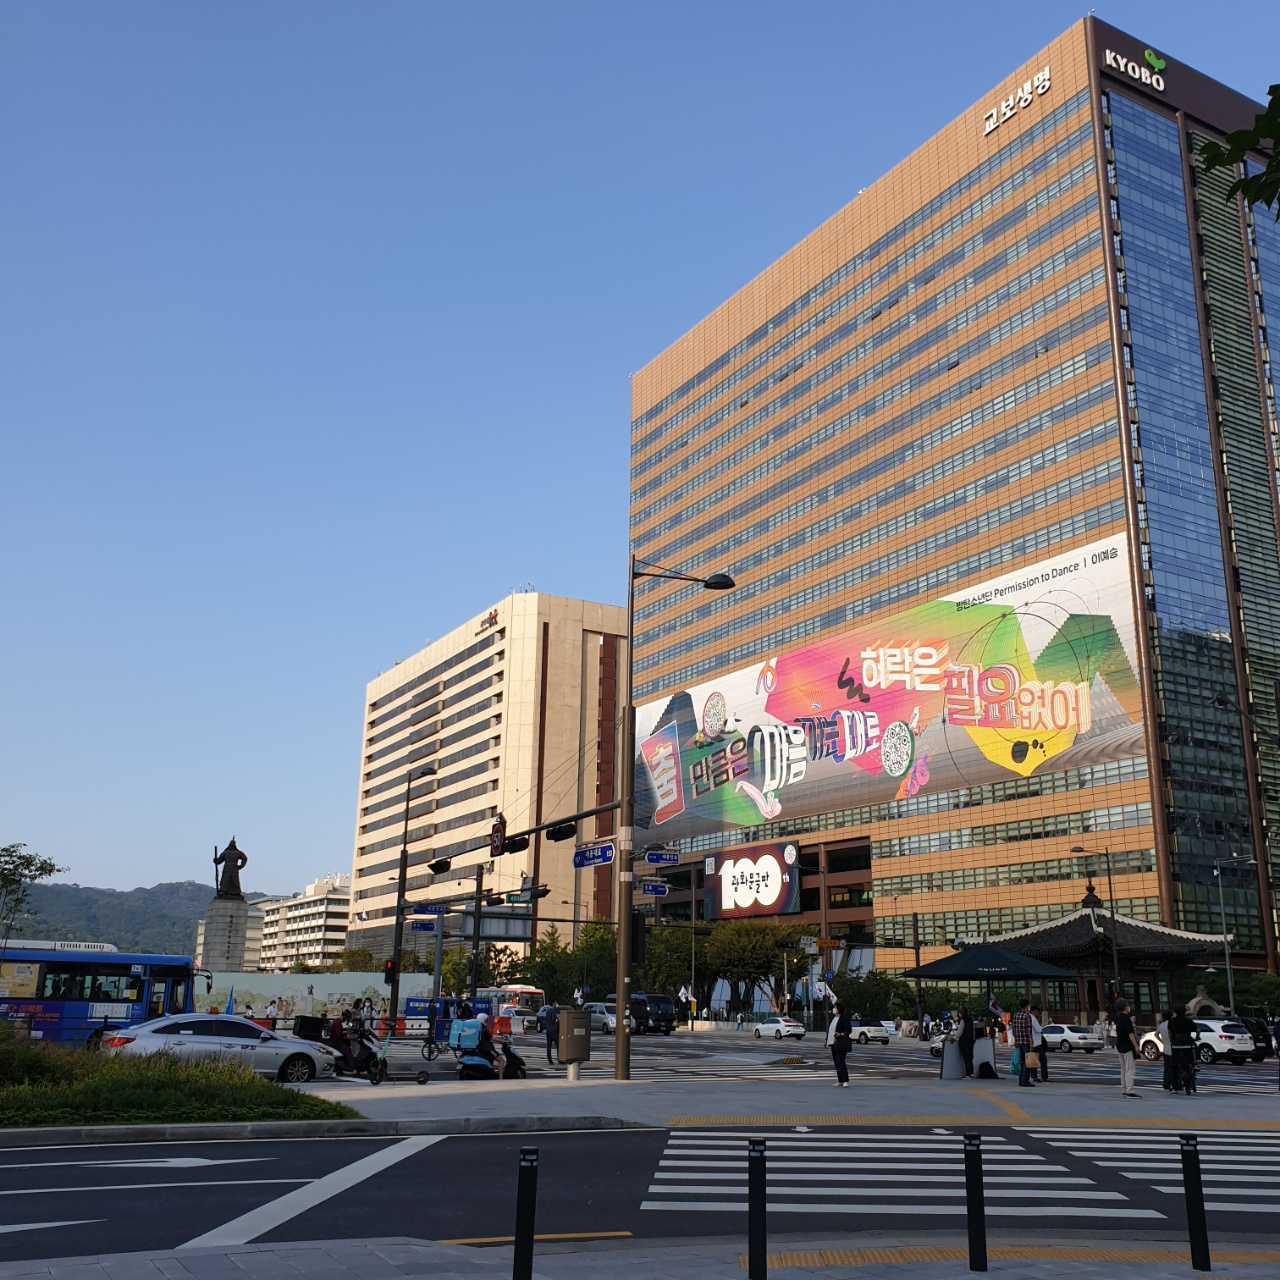

In [17]:
def init_widgets(url):
  image_text = widgets.Text(
    description="Image URL", layout=Layout(minwidth="70%")
  )

  image_text.value = url
  submit_button = widgets.Button(description="Caption the image!")

  display(image_text)
  display(submit_button)

  submit_button.on_click(lambda b: on_button_click(
      b, image_text
  ))
  
  return image_text
  
def on_button_click(b, image_text):   # 'Caption the image!' 버튼을 선택하면 이미지 캡셔닝이 진행됨.
  clear_output()
  image_path = feature_extractor.get_actual_image(image_text.value)
  image = Image.open(image_path)
  
  captions = '<br>'.join(get_captions(feature_extractor(image_text.value)))
  init_widgets(image_text.value)
  display(image)
  
  display(HTML(captions))

image_text = init_widgets(
    "https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdTY3bH%2Fbtrh6IW1IOx%2FBtgYEl2ZxuyGupVuKJS2Q1%2Fimg.jpg"
)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[tensor([[0.0000, 4.6022, 7.4206,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 8.9066,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 4.9022, 0.7001,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 4.5125, 0.0000,  ..., 0.0000, 0.0524, 0.0000],
        [0.0000, 0.7557, 0.0000,  ..., 3.6552, 0.0446, 0.0000]],
       device='cuda:0')]
[tensor([[0.0000, 4.6022, 7.4206,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 8.9066,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 4.9022, 0.7001,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 4.5125, 0.0000,  ..., 0.0000, 0.0524, 0.0000],
        [0.0000, 0.7557, 0.0000,  ..., 3.6552, 0.0446, 0.0000]],
       device='cuda:0')]


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


Text(value='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn…

Button(description='Caption the image!', style=ButtonStyle())

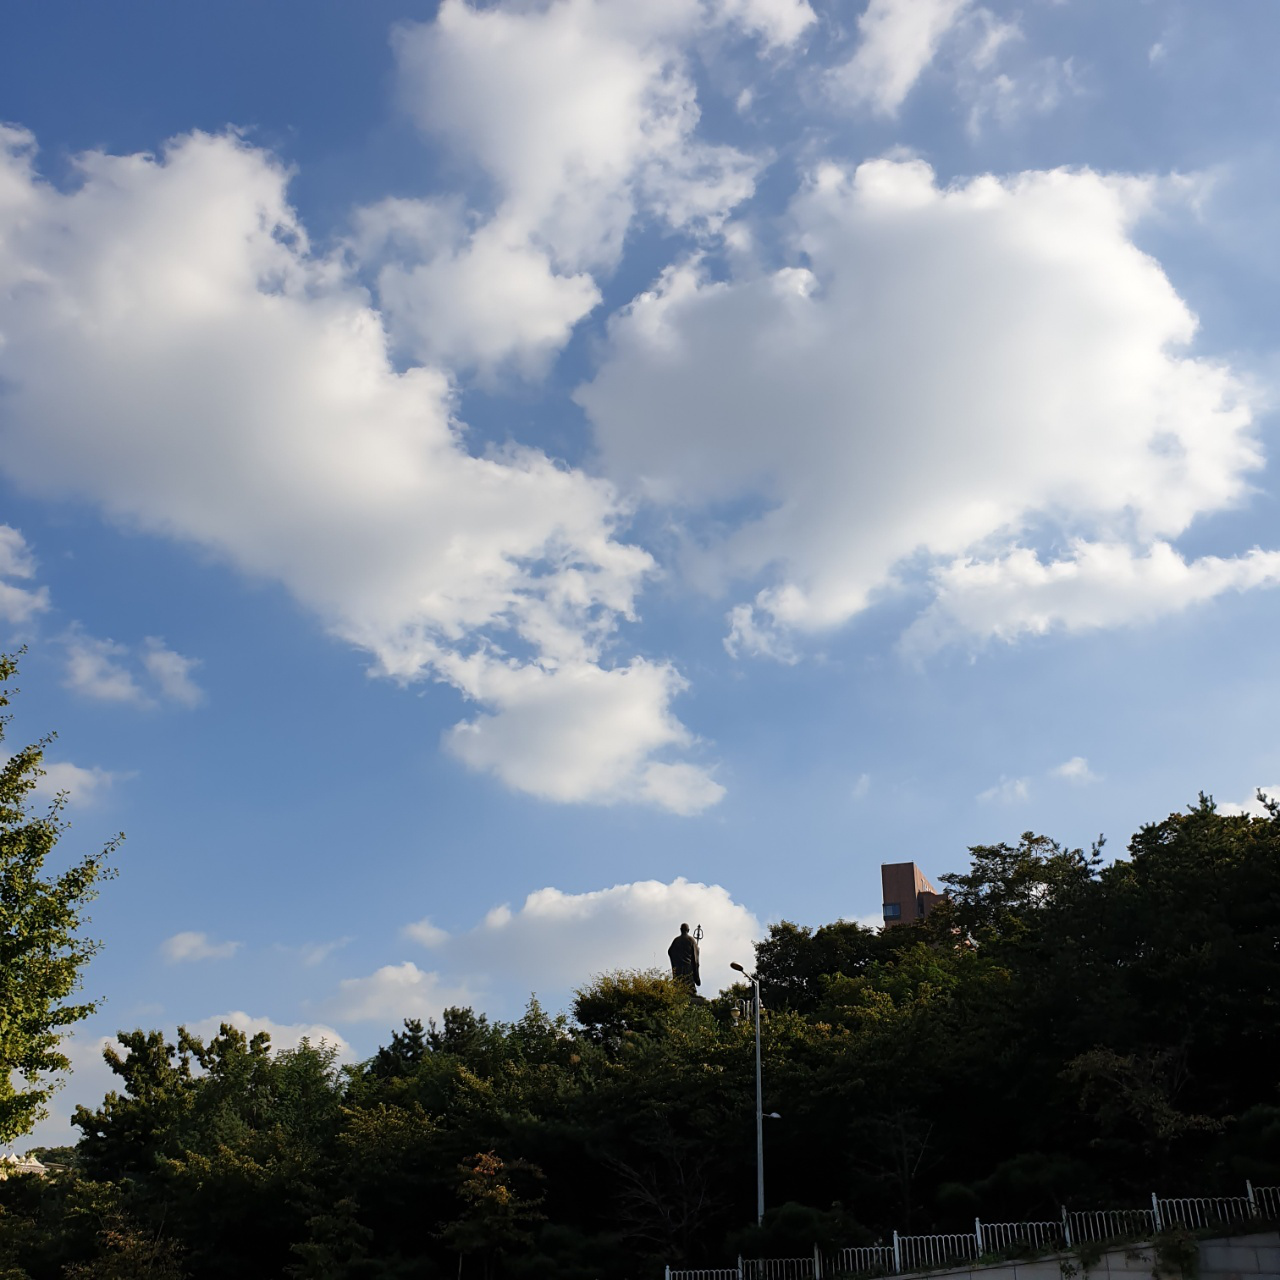

In [18]:
def init_widgets(url):
  image_text = widgets.Text(
    description="Image URL", layout=Layout(minwidth="70%")
  )

  image_text.value = url
  submit_button = widgets.Button(description="Caption the image!")

  display(image_text)
  display(submit_button)

  submit_button.on_click(lambda b: on_button_click(
      b, image_text
  ))
  
  return image_text
  
def on_button_click(b, image_text):   # 'Caption the image!' 버튼을 선택하면 이미지 캡셔닝이 진행됨.
  clear_output()
  image_path = feature_extractor.get_actual_image(image_text.value)
  image = Image.open(image_path)
  
  captions = '<br>'.join(get_captions(feature_extractor(image_text.value)))
  init_widgets(image_text.value)
  display(image)
  
  display(HTML(captions))

image_text = init_widgets(
    "https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcVCLfb%2FbtriaQGABex%2FkYEI4w3XoOJ0b8WyNReoC1%2Fimg.jpg"
)